In [29]:
%matplotlib inline
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm

### test DA scheme

In [31]:
def OI(xb, yo, Pb, R, H_func=None, H=None):
    """
    Optimal interpolation.
    
    Parameters:
    ----------
    xb: 1d array, shape=(n,)
        State vector of background with n dimension.
    yo: 1d array, shape=(p,)
        Observation. 'p' is number of observations.
    Pb: 2d array, shape=(n,n)
        Background error covariance.
    R: 2d array, shape=(p,p)
        Observation error covariance.
    H_func: optional. callable function
        Observational operator.
        Its input and output are shape (n,) and (p,) array.
        It is necessary if n != p.
    H: optional. 2d array, shape=(n,p)
        Jocobian of H_func.
        It is necessary if n != p.
        
    Return:
    ------
    xa: 1d array, shape=(n,)
        State vector of analysis.
    Pa: 2d array, shape=(n,n)
        Analysis error covariance.
    """
    if H_func is None:
        if len(xb) != len(yo):
            raise ValueError(f"len(xb) should equal to len(yo): {len(xb)} != {len(yo)}")
        K = Pb @ np.linalg.inv(Pb + R)
        xa = xb + K @ (yo - xb)
        Pa = (np.eye(len(xb)) - K) @ Pb
    else:
        K = Pb @ H.T @ np.linalg.inv(H @ Pb @ H.T + R)
        xa = xb + K @ (yo - H_func(xb))
        Pa = (np.eye(len(xb)) - K @ H) @ Pb
    
    return (xa, Pa)

### nature run

In [32]:
## X = [[x0, x1, x2, ....],
##      [y0, y1, y2, ....],
##      [z0, z1, z2, ....]]


# spin up
spinup_time = 5
dt = 0.01
#X0 = np.array([[10.1], [-0.5], [40.1]])
X0_nature = np.array([[0], [5], [30]])
X_spn = lorenz63_fdm(X0_nature.ravel(), np.arange(0, spinup_time, dt))

# save nature run
time = 40
dt = 0.01
ts = np.arange(spinup_time, spinup_time+time, dt)
X0 = X_spn[:,[-1]]
X_nature = lorenz63_fdm(X0.ravel(), ts)

### generate obs

In [33]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

In [42]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [5, 5, 5]
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 2
cycle_num = int(time / obs_timeintv)

# construct observation error
X_obs_err = np.zeros((3, cycle_num))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_normal(obsm, obsv, cycle_num, rst)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

### initial condition

In [43]:
# spin up and get initial condition for experiments
# random_state=9 is very close to nature run
X0 = X0_nature + gen_random_normal(0, 5, size=1, random_state=30)
X_spn = lorenz63_fdm(X0.ravel(), np.arange(0, spinup_time, dt))

X_ini = X_spn[:,[-1]]
X_ini

array([[-5.22694966],
       [-6.44985479],
       [20.87602827]])

### NMC 1

In [44]:
def nmc(model, ref, dt, alpha, t1, t2, num):
    result = np.zeros((num, 2, ref[:,0].size))
    interv = int((t2-t1) / dt)
    for n in range(num):
        x0 = ref[:,n*interv]
        ts = np.arange(0, t2, dt)
        xs = model(x0, ts)
        result[n,0,:] = xs[:,int(t1/dt)]
        result[n,1,:] = xs[:,-1]
    """    
    Pb = np.zeros((x0.size, x0.size))
    diff_t2t1 = result[:,1,:] - result[:,0,:]
    for n in range(num):
        Pb += diff_t2t1[n,np.newaxis].T * diff_t2t1[n,:]
    """
    Pb = np.zeros((x0.size, x0.size))
    for n in range(1, num):
        xf_diff = result[n,0,:] - result[n-1,1,:]
        Pb += xf_diff[:,np.newaxis] * xf_diff
        
    return alpha * Pb / num

In [45]:
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
Pb = nmc(lorenz63_fdm, X_nature, dt, alpha=50, t1=1, t2=2, num=20)
Pb

array([[ 8.76499608,  9.10178817,  5.21540705],
       [ 9.10178817, 13.58905138,  4.59478095],
       [ 5.21540705,  4.59478095, 16.94171384]])

### NMC 2

In [46]:
# observation error covariance and initial background error covariance
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
Pb = np.zeros((X_ini.size, X_ini.size))
np.fill_diagonal(Pb, obs_var)

# assimilation
cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

niter = 100
Pb_history = np.zeros((Pb.size, niter))
# ====== test iter =====
for i in range(niter):
    if i%10 == 0:
        print(f'----- i = {i} -----')
        print(Pb)
        print()
    Pb_history[:,i] = Pb.ravel()
    
    # start cycle assimilation
    for nc in range(cycle_num):
        # calculate analysis field, then forecast
        xa = OI(xb, X_obs[:,[nc]], Pb, R)[0]
        x = lorenz63_fdm(xa.ravel(), ts)
        result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x

        # for next cycle
        xb = x[:,[-1]]
        t_start = int(ts[-1] + dt)
        ts = np.arange(t_start, t_start+cycle_len, dt)

    # use `result` (assimilation result) as reference to apply NMC
    ref = result
    Pb = nmc(lorenz63_fdm, ref, dt, alpha=1, t1=1, t2=2, num=30)

print(f'----- i = {i+1} -----')
print(Pb)

----- i = 0 -----
[[5. 0. 0.]
 [0. 5. 0.]
 [0. 0. 5.]]

----- i = 10 -----
[[ 99.84454929 124.70464737  10.82776   ]
 [124.70464737 166.95158877  13.61684613]
 [ 10.82776     13.61684613  48.15165471]]

----- i = 20 -----
[[ 99.401879   122.22176     10.94826707]
 [122.22176    166.1625914    8.29986443]
 [ 10.94826707   8.29986443  56.06823691]]

----- i = 30 -----
[[ 79.53293926  90.16100766  13.78127555]
 [ 90.16100766 115.83056672  25.98008769]
 [ 13.78127555  25.98008769  67.77973582]]

----- i = 40 -----
[[106.80883821 111.51882384   9.7008902 ]
 [111.51882384 125.29150987   6.51626406]
 [  9.7008902    6.51626406  46.00305958]]

----- i = 50 -----
[[ 96.32192866 117.98694802  -0.16594172]
 [117.98694802 160.15625053   7.44595903]
 [ -0.16594172   7.44595903  50.74221335]]

----- i = 60 -----
[[ 63.33227922  79.98966004   8.87475713]
 [ 79.98966004 110.58295507  13.98946953]
 [  8.87475713  13.98946953  58.82755612]]

----- i = 70 -----
[[ 72.52432013  86.02739906 -10.77494036]
 

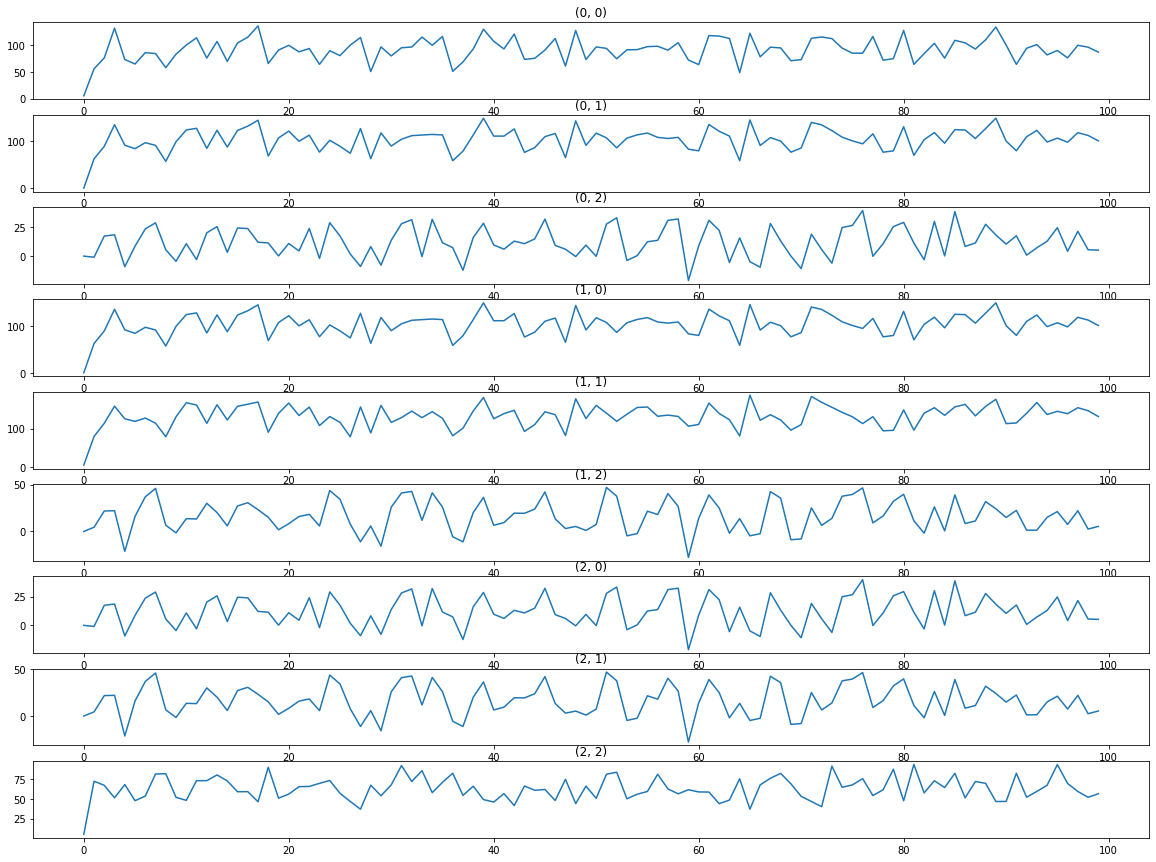

In [47]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(20, 15))
for i in range(9):
    ax[i].plot(Pb_history[i,:])
    ax[i].set_title(f'({i//3}, {i%3})')

In [48]:
Pb = Pb_history[:,int(niter/2):].mean(axis=1).reshape((3,3))
Pb

array([[ 93.01377953, 107.308151  ,  12.8851294 ],
       [107.308151  , 136.33392387,  16.80275235],
       [ 12.8851294 ,  16.80275235,  64.06822709]])